In [1]:
import os
import sys
import logging

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../')))
logger = logging.getLogger(__name__)

import re
import pandas as pd
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from config.config import CONFIG
from src.data_processing import load_processed_data

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
supervised_data = load_processed_data(CONFIG['supervised_path'])
unsupervised_data = load_processed_data(CONFIG['unsupervised_path'])

2025-03-02 13:27:52,279 - INFO - Loading processed data from 'F:/VSCPROJ/imdb/core/data/processed/supervised_data.csv'...
2025-03-02 13:27:52,902 - INFO - Data loaded successfully.
2025-03-02 13:27:52,903 - INFO - Loading processed data from 'F:/VSCPROJ/imdb/core/data/processed/unsupervised_data.csv'...
2025-03-02 13:27:53,540 - INFO - Data loaded successfully.


In [3]:
logger.info('Beginning EDA with pandas functions...')
logger.info('Supervised data analysis...')
logger.info(f"Supervised data shape: {supervised_data.shape}")
logger.info(f"Supervised data sample:\n{supervised_data.sample(15)}")
logger.info(f"Supervised data columns:\n{supervised_data.columns.tolist()}")
logger.info(f"Supervised columns data types:\n{supervised_data.dtypes}")
logger.info(f"Supervised data description:\n{supervised_data.describe()}")
logger.info(f"Supervised data missing values:\n{supervised_data.isnull().sum()}")
logger.info(f"Supervised data duplicates: {supervised_data.duplicated().sum()}")


logger.info('\n\n\n\nUnsupervised data analysis...')
logger.info(f"Unsupervised data shape: {unsupervised_data.shape}")
logger.info(f"Unsupervised data sample:\n{unsupervised_data.sample(15)}")
logger.info(f"Unsupervised data columns:\n{unsupervised_data.columns.tolist()}")
logger.info(f"Unsupervised columns data types:\n{unsupervised_data.dtypes}")
logger.info(f"Unsupervised data description:\n{unsupervised_data.describe()}")
logger.info(f"Unsupervised data missing values:\n{unsupervised_data.isnull().sum()}")
logger.info(f"Unsupervised data duplicates: {unsupervised_data.duplicated().sum()}")

2025-03-02 13:27:53,558 - INFO - Beginning EDA with pandas functions...
2025-03-02 13:27:53,558 - INFO - Supervised data analysis...
2025-03-02 13:27:53,559 - INFO - Supervised data shape: (49582, 4)
2025-03-02 13:27:53,572 - INFO - Supervised data sample:
                                                  review  sentiment  score  \
43170  i just got done watching this movie and i have...          0      4   
5918   This is a film exploring the female sexuality ...          1     10   
16373  The only thing that kept me from vomiting afte...          0      1   
27574  Great horror comedy from Michael Davis.Iwas la...          1      9   
3201   I love this movie and have seen it quite a few...          1     10   
40265  Wow ... This movie really really sucks ... 'Nu...          0      1   
42404  Other than John Krasinski , this movie was abs...          0      2   
34418  It may not_have had the big budgets , celebrit...          1     10   
46301  I am just throwing in this review 

In [4]:
fig = px.histogram(supervised_data, x='sentiment', nbins=2, title='Sentiment Distribution', labels={'sentiment': 'Sentiment', 'count': 'Review Count}'}, color='sentiment', template='plotly_dark')
fig.update_layout(xaxis_title='Sentiment', yaxis_title='Review Count', bargap=0.2)
fig.show()

In [5]:
fig = px.histogram(supervised_data, 
                   x='score', 
                   category_orders={'score': ['1', '2', '3', '4', '7', '8', '9', '10']}, 
                   title='Score Distribution', 
                   labels={'score': 'Score', 'count': 'Review Count'},
                   color='sentiment',  
                   template='plotly_dark')
fig.update_layout(xaxis_title='Score', yaxis_title='Review Count', bargap=0.2)
fig.show()

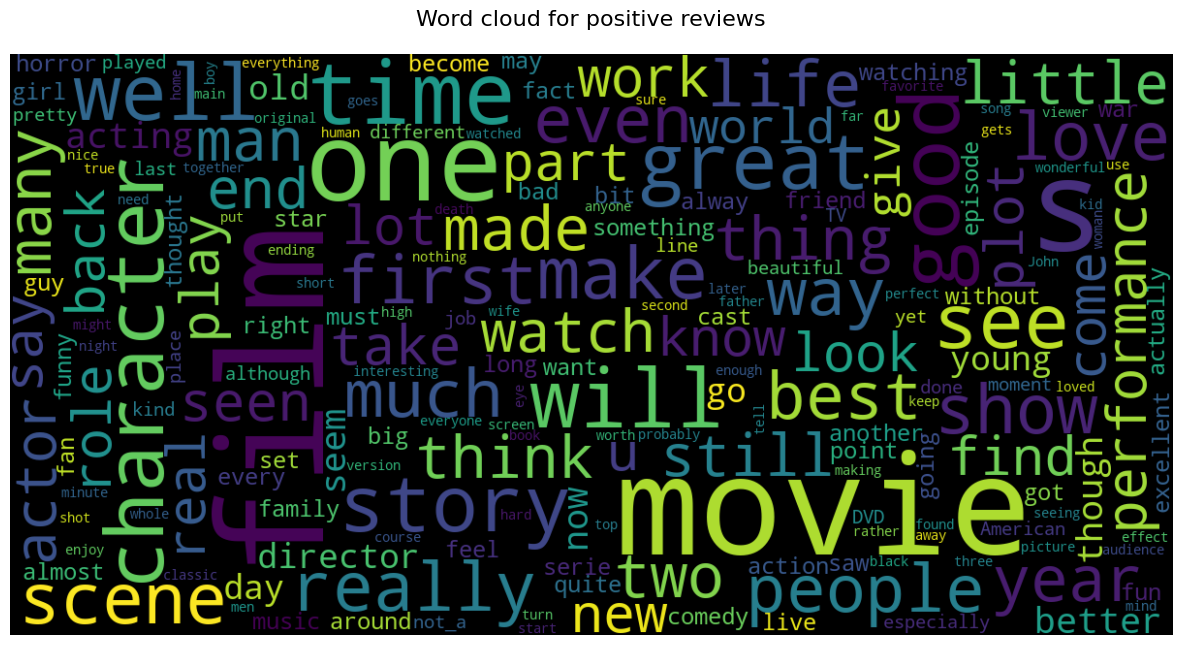

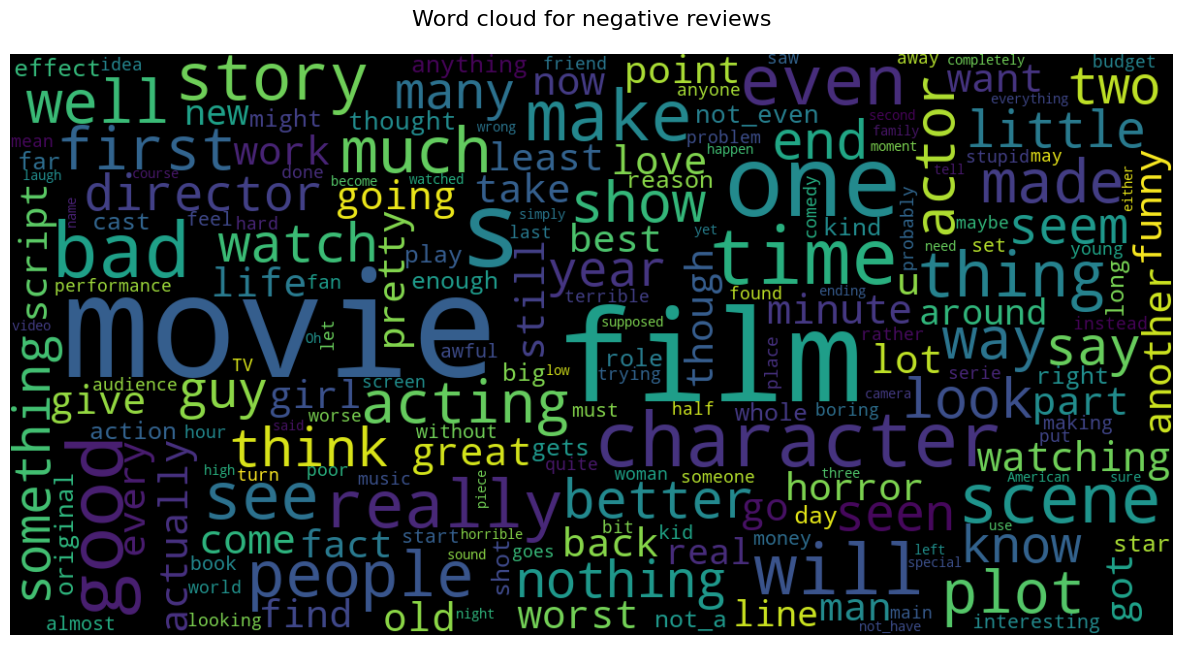

In [6]:
def generate_wordcloud(text, title):
    """
    Generates a word cloud from the text
    
    Args:
        text (str): The text to generate the word cloud from
        title (str): The title of the word cloud
    """
    wordcloud = WordCloud(
        width=1200, 
        height=600,
        background_color='black',
        min_font_size=10,
        max_font_size=150,
        max_words=200,
        collocations=False
    ).generate(text)
    
    plt.figure(figsize=(15, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16, pad=20)
    plt.show()

positive_reviews = supervised_data[supervised_data['sentiment'] == 1]['review']
negative_reviews = supervised_data[supervised_data['sentiment'] == 0]['review']

positive_text = ' '.join(positive_reviews)
negative_text = ' '.join(negative_reviews)

generate_wordcloud(positive_text, 'Word cloud for positive reviews')
generate_wordcloud(negative_text, 'Word cloud for negative reviews')

In [7]:
supervised_data['review_length'] = supervised_data['review'].apply(len)

fig = px.box(supervised_data,
             x='sentiment',
             y='review_length',
             color='sentiment',
             title='Review Length Distribution',
             labels={'review_length': 'Review Length', 'sentiment': 'Sentiment'},
             template='plotly_dark')
fig.show()

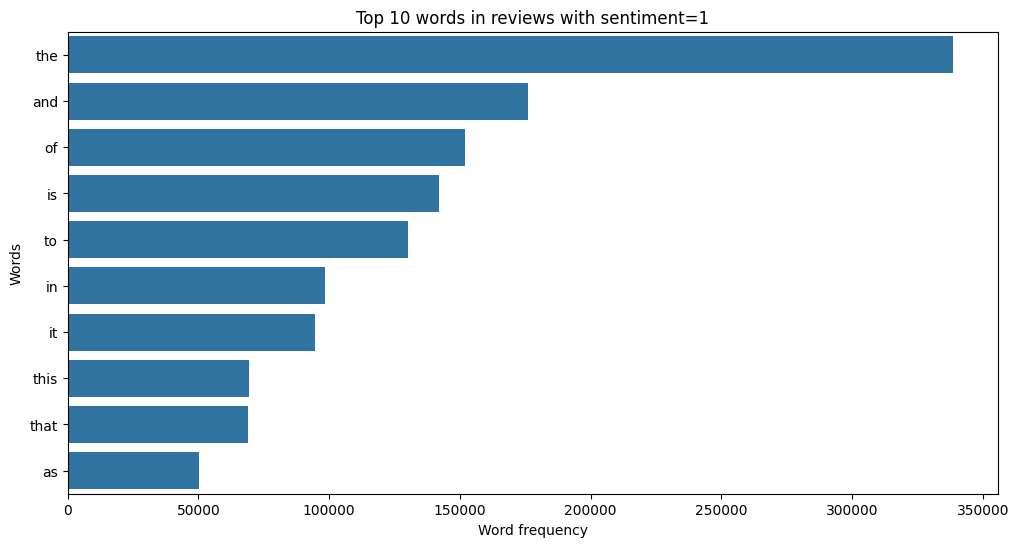

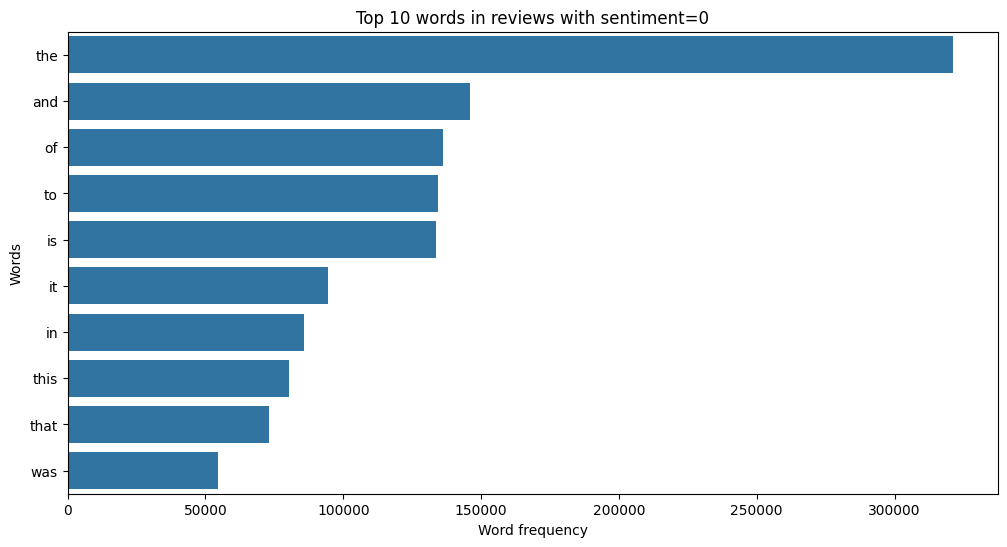

In [8]:
def plot_top_words(data, sentiment, n=10):
    """
    Plots the top n words in the reviews of a given sentiment
    
    Args:
        data (pd.DataFrame): The data to plot from
        sentiment (int): The sentiment to plot (0 или 1)
        n (int): The number of words to plot
    """
    reviews = data[data['sentiment'] == sentiment]['review']
    vectorizer = CountVectorizer(max_features=n)
    word_counts = vectorizer.fit_transform(reviews)
    word_freq = dict(zip(vectorizer.get_feature_names_out(), word_counts.toarray().sum(axis=0)))
    word_freq = dict(sorted(word_freq.items(), key=lambda x: x[1], reverse=True))
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x=list(word_freq.values()), y=list(word_freq.keys()))
    plt.title(f"Top {n} words in reviews with sentiment={sentiment}")
    plt.xlabel('Word frequency')
    plt.ylabel('Words')
    plt.show()


plot_top_words(supervised_data, 1)  
plot_top_words(supervised_data, 0)

In [9]:
fig = px.scatter(supervised_data,
                 x='score',
                 y='review_length',
                 color='sentiment',
                 title='Score Correlation with Review Length',
                 labels={'score': 'Score', 'review_length': 'Review Length'},
                 template='plotly_dark')
fig.show()